# <center> Where are the restaurants in Montréal ? </center>
<br>

<img src='https://meetings.mtl.org/sites/meetings/files/styles/hero/public/2018-03/33751.jpg?itok=Dg4m-lW3' width="800" height="800">

July 16th, 2021

# Table of content
    1. Introduction
    2. Data Gathering
    3. Data Manipulation
    4. Mapping the top 10 neighborhoods for each categories
    5. Training of the clustering algorithm
    6. Analysis of the clusters
    7. Conclusion

# 1. Introduction

Whether you are visiting Montréal or are interested in opening a restaurant, it is good to know where the current restaurants are. Montréal has a lot to offer in terms of nightlife, cafés and restaurant. But where to start if you don't know the city ?

As part of the IBM Data Science Certification, students like me have to do a capstone project leveraging the Foursquare API. The API makes it possible to know a lot of information about venues around a point of interest. We can therefore make a list of the venues in the Montréal neighborhoods and make maps and charts to show where to go to find what you are looking for.

To make this project possible, I used a list of postal codes and the associated neighborhood found on this wikipedia page : https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_H. With these informations, I was able to find the coordinates of each neighborhood, which allowed me to create a map of Montréal and it's neighborhoods. I also used the coordinates to find venues in each neighborhoods using the Foursquare API.

Once I have the informations about the kind of venues found in each neighborhoods, I can use a clustering algorithm to make clusters of similar neighborhoods.

# 2. Data Gathering

In [1]:
import pandas as pd
import numpy as np
import requests
import pgeocode
import folium
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from yellowbrick.cluster import SilhouetteVisualizer

## Get the postal codes from wikipedia

In [2]:
postal_codes_url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_H'
montreal_wiki = pd.read_html(postal_codes_url)[0]

In [3]:
montreal_wiki

,0,1,2,3,4,5,6,7,8
0,H0ANot assigned,H1APointe-aux-Trembles,"H2ASaint-Michel,East",H3ADowntown Montreal North(McGill University),H4ANotre-Dame-de-GrâceNortheast,H5APlace Bonaventure,H7ADuvernay-Est,H8ANot assigned,H9ADollard-des-OrmeauxNorthwest
1,H0BNot assigned,H1BMontreal East,H2BAhuntsicNorth,H3BDowntown MontrealEast,H4BNotre-Dame-de-GrâceSouthwest,H5BPlace Desjardins,H7BSaint-François,H8BNot assigned,H9BDollard-des-OrmeauxEast
2,H0CNot assigned,H1CRivière-des-PrairiesNortheast,H2CAhuntsicCentral,H3CGriffintown(Includes Île Notre-Dame & Île S...,H4CSaint-Henri,H5CNot assigned,H7CSaint-Vincent-de-Paul,H8CNot assigned,H9CL'Île-BizardNortheast
3,H0ENot assigned,H1ERivière-des-PrairiesSouthwest,H2EVillerayNortheast,H3EL'Île-Des-Soeurs,H4EVille Émard,H5ENot assigned,H7EDuvernay,H8ENot assigned,H9EL'Île-BizardSouthwest
4,H0GNot assigned,H1GMontréal-NordNorth,H2GPetite-PatrieNortheast,H3GDowntown MontrealSoutheast (Concordia Unive...,H4GVerdunNorth,H5GNot assigned,H7GPont-Viau,H8GNot assigned,H9GDollard-des-OrmeauxSouthwest
5,H0HReserved0H0: Santa Claus,H1HMontréal-NordSouth,H2HPlateau Mont-RoyalNorth,H3HDowntown MontrealSouthwest,H4HVerdunSouth,H5HNot assigned,H7HAuteuilWest,H8HNot assigned,H9HSainte-Geneviève / Pierrefonds
6,H0JNot assigned,H1JAnjouWest,H2JPlateau Mont-RoyalNorth Central,H3JPetite-Bourgogne,H4JCartiervilleCentral,H5JNot assigned,H7JAuteuilNortheast,H8JNot assigned,H9JKirkland
7,H0KNot assigned,H1KAnjouEast,H2KCentre-SudNorth,H3KPointe-Saint-Charles,H4KCartiervilleSouthwest,H5KNot assigned,H7KAuteuilSouth,H8KNot assigned,H9KSenneville
8,H0LNot assigned,H1LMercierNorth,H2LCentre-SudSouth,H3LAhuntsicSouthwest,H4LSaint-LaurentInner Northeast,H5LNot assigned,H7LSainte-Rose,H8LNot assigned,H9LNot assigned
9,H0MAkwesasne Region1A0: Akwesasne,H1MMercierWest,H2MAhuntsicEast,H3MCartiervilleNortheast,H4MSaint-LaurentEast,H5MNot assigned,H7MVimont,H8MNot assigned,H9MNot assigned


In [4]:
update_dict = {}
montreal_df = pd.DataFrame()
replace_dict = {'Akwesasne Region1A0: ':'', 'North':'','South':'','East':'','West':''}

for col in range(len(montreal_wiki.columns)):
    for row in range(len(montreal_wiki)):
        text = montreal_wiki.loc[row,col]
        if 'Not assigned' in text:
            continue
        if 'H0H' in text[0:3]:
            continue
        update_dict['PostalCode'] = text[0:3]
        update_dict['Neighborhood'] = text[3:].replace('Akwesasne Region1A0: ','').replace('North','').replace('South','').replace('East','').replace('east','').replace('West','').replace('west','').replace(',','')
        montreal_df = montreal_df.append(update_dict, ignore_index=True)

In [5]:
montreal_df.head(10)

,Neighborhood,PostalCode
0,Akwesasne,H0M
1,Pointe-aux-Trembles,H1A
2,Montreal,H1B
3,Rivière-des-Prairies,H1C
4,Rivière-des-Prairies,H1E
5,Montréal-Nord,H1G
6,Montréal-Nord,H1H
7,Anjou,H1J
8,Anjou,H1K
9,Mercier,H1L


In [6]:
montreal_df.shape

(122, 2)

## Get the coordinates associated with the postal code

In [7]:
pgeocode.Nominatim('ca')
geolocator = pgeocode.Nominatim('ca')
update_coords_dict = {}
montreal_coords_df = pd.DataFrame()

for i, PostalCode in enumerate(montreal_df['PostalCode']):
    # initialize your variable to None
    #print(f'--Getting Postal Code: {postal_code}')
    g = geolocator.query_postal_code(PostalCode)
    
    if not g.empty:
        #print(f'Postal Code {postal_code} has been retrieved. {len(postal_codes) - (i + 1)} codes left')
        update_coords_dict['Latitude'] = g.latitude
        update_coords_dict['Longitude'] = g.longitude
        update_coords_dict['PostalCode'] = PostalCode
        montreal_coords_df = montreal_coords_df.append(update_coords_dict, ignore_index=True)
        
montreal_coords_df

,Latitude,Longitude,PostalCode
0,45.6986,-73.5025,H0M
1,45.6753,-73.5016,H1A
2,45.6320,-73.5075,H1B
3,45.6656,-73.5367,H1C
4,45.6342,-73.5842,H1E
...,...,...,...
117,45.4679,-73.7748,H9P
118,45.4487,-73.8167,H9R
119,45.4414,-73.7749,H9S
120,45.4334,-73.8659,H9W


In [8]:
montreal_df = montreal_df.join(montreal_coords_df.set_index('PostalCode'), on='PostalCode')
montreal_df

,Neighborhood,PostalCode,Latitude,Longitude
0,Akwesasne,H0M,45.6986,-73.5025
1,Pointe-aux-Trembles,H1A,45.6753,-73.5016
2,Montreal,H1B,45.6320,-73.5075
3,Rivière-des-Prairies,H1C,45.6656,-73.5367
4,Rivière-des-Prairies,H1E,45.6342,-73.5842
...,...,...,...,...
117,DorvalOutskirts,H9P,45.4679,-73.7748
118,Pointe-Claire,H9R,45.4487,-73.8167
119,Dorval / L'Île-Dorval,H9S,45.4414,-73.7749
120,Beaconsfield,H9W,45.4334,-73.8659


## Making a map of Montréal and it's neighborhoods

In [9]:
latitude, longitude = 45.508888, -73.561668

# create map using latitude and longitude values
map_montreal = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(montreal_df['Latitude'], montreal_df['Longitude'], montreal_df['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_montreal)  
    
map_montreal

In [10]:
CLIENT_ID = 'PV5DTIJMZJ24IJVHMI5IEKAOE0YMCA5RUCCLB0TJMYEK2LLC'
CLIENT_SECRET = 'Z4IJRDRSAUB3FJTBX0FXPATRLAH5NZHJX5L3NSJG4TJI5EO0'
ACCESS_TOKEN = 'L1CUPPTSIJQOKYSWBVW2Y1KTYWMFTVRDDR2Q4BUAZKXS3EU2'
VERSION = '20210715' # Foursquare API version
LIMIT = 500 # A default Foursquare API limit value

## The Foursquare API make it possible to know the venues around a point of interest

In [11]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [12]:
montreal_venues = getNearbyVenues(montreal_df['Neighborhood'], montreal_df['Latitude'], montreal_df['Longitude'])

## We now have a dataset of the venues in Montréal

In [13]:
montreal_venues

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Akwesasne,45.6986,-73.5025,Site Historique National De La Bataille De La ...,45.699499,-73.505149,Historic Site
1,Pointe-aux-Trembles,45.6753,-73.5016,Parc-nature de la Pointe-aux-Prairies,45.678834,-73.501162,Park
2,Pointe-aux-Trembles,45.6753,-73.5016,AMT Gare Pointe-aux-Trembles,45.674882,-73.504908,Train Station
3,Pointe-aux-Trembles,45.6753,-73.5016,Parc Yves-Thériault,45.678675,-73.502037,Park
4,Montreal,45.6320,-73.5075,Restaurant Sunshine,45.631091,-73.508728,Sushi Restaurant
...,...,...,...,...,...,...,...
1915,Sainte-Anne-De-Bellevue,45.4062,-73.9456,Marché Richelieu - J. Raymond Richard,45.405371,-73.950396,Grocery Store
1916,Sainte-Anne-De-Bellevue,45.4062,-73.9456,AMT Gare Sainte-Anne-de-Bellevue,45.407761,-73.950959,Train Station
1917,Sainte-Anne-De-Bellevue,45.4062,-73.9456,Resto Pub Bord'Eaux,45.403015,-73.949254,Gastropub
1918,Sainte-Anne-De-Bellevue,45.4062,-73.9456,Farmers Market Ste-Anne-de-Bellevue,45.403563,-73.950242,Farmers Market


Here are the unique venue categories and the count for each one :

In [14]:
montreal_venues['Venue Category'].value_counts()

Café                         106
Restaurant                    70
Park                          67
Hotel                         57
French Restaurant             50
                            ... 
Irish Pub                      1
Fish Market                    1
Belgian Restaurant             1
Tex-Mex Restaurant             1
Cajun / Creole Restaurant      1
Name: Venue Category, Length: 260, dtype: int64

Here are the unique venues and the count for each one :

In [15]:
montreal_venues['Venue'].value_counts()

Pharmacie Jean Coutu     23
Couche-Tard              18
Subway                   18
Tim Hortons              14
Pharmaprix               11
                         ..
MELK Bar à Café           1
Amiens                    1
Pâtisserie de la Gare     1
Promenade Fleury          1
Madre                     1
Name: Venue, Length: 1428, dtype: int64

# 3. Data Manipulation

## I want custom made categories for the sake of the analysis I want to make

Let's build the lists of venue categories to group together :

In [16]:
rest_list = ['Restaurant', 'Pizza', 'Breakfast', 'Sandwich', 'Gastropub', 'Burger Joint', 'Deli / Bodega', 'Steakhouse','Diner','Taco','Creperie','BBQ Joint','Salad Place','Gourmet Shop','Bistro','Noodle House','Fried Chicken Joint','Hot Dog Joint','Poutine Place','Burrito Place']
dessert_list = ['Ice Cream', 'Dessert']
cafe_list = ['Café', 'Coffee']
togo_list = ['Bakery', 'Grocery','Food & Drink Shop','Bagel Shop','Cheese Shop','Beer Store','Cupcake Shop','Donut Shop','Food Truck','Frozen Yogurt Shop','Pastry Shop','Health Food Store','Fish & Chips Shop','Sausage Shop','Fish Market','Fressers','Fruit & Vegetable Store','Pie Shop','Snack Place']
bar_list = ['Bar','Nightclub','Pub', 'Lounge','Brewery','Speakeasy']
tea_list = ['Tea Room','Bubble Tea Shop']

In [17]:
print('Venue types :',montreal_venues['Venue Category'].value_counts().unique().sum())
print('Venues :',montreal_venues['Venue Category'].count())

Venue types : 972
Venues : 1920


Let's one-hot encode the venues :

In [18]:
for row in range(len(montreal_venues)):
    for element in rest_list:
        if element in montreal_venues.loc[row,'Venue Category']:
            montreal_venues.loc[row, 'Restaurant'] = 1
            break
        else:
            montreal_venues.loc[row, 'Restaurant'] = 0
    
    for element in dessert_list:
        if element in montreal_venues.loc[row,'Venue Category']:
            montreal_venues.loc[row, 'Dessert'] = 1
            break
        else:
            montreal_venues.loc[row, 'Dessert'] = 0
            
    for element in cafe_list:
        if element in montreal_venues.loc[row,'Venue Category']:
            montreal_venues.loc[row, 'Coffee'] = 1
            break
        else:
            montreal_venues.loc[row, 'Coffee'] = 0
    
    for element in togo_list:
        if element in montreal_venues.loc[row,'Venue Category']:
            montreal_venues.loc[row, 'To Go'] = 1
            break
        else:
            montreal_venues.loc[row, 'To Go'] = 0
            
    for element in bar_list:
        if element in montreal_venues.loc[row,'Venue Category']:
            montreal_venues.loc[row, 'Bar'] = 1
            break
        else:
            montreal_venues.loc[row, 'Bar'] = 0
            
    for element in tea_list:
        if element in montreal_venues.loc[row,'Venue Category']:
            montreal_venues.loc[row, 'Tea'] = 1
            break
        else:
            montreal_venues.loc[row, 'Tea'] = 0

montreal_venues = montreal_venues.astype({'Restaurant': np.int,'Dessert': np.int,'Coffee': np.int, 'To Go': np.int, 'Bar': np.int,'Tea':np.int})
montreal_venues

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Restaurant,Dessert,Coffee,To Go,Bar,Tea
0,Akwesasne,45.6986,-73.5025,Site Historique National De La Bataille De La ...,45.699499,-73.505149,Historic Site,0,0,0,0,0,0
1,Pointe-aux-Trembles,45.6753,-73.5016,Parc-nature de la Pointe-aux-Prairies,45.678834,-73.501162,Park,0,0,0,0,0,0
2,Pointe-aux-Trembles,45.6753,-73.5016,AMT Gare Pointe-aux-Trembles,45.674882,-73.504908,Train Station,0,0,0,0,0,0
3,Pointe-aux-Trembles,45.6753,-73.5016,Parc Yves-Thériault,45.678675,-73.502037,Park,0,0,0,0,0,0
4,Montreal,45.6320,-73.5075,Restaurant Sunshine,45.631091,-73.508728,Sushi Restaurant,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1915,Sainte-Anne-De-Bellevue,45.4062,-73.9456,Marché Richelieu - J. Raymond Richard,45.405371,-73.950396,Grocery Store,0,0,0,1,0,0
1916,Sainte-Anne-De-Bellevue,45.4062,-73.9456,AMT Gare Sainte-Anne-de-Bellevue,45.407761,-73.950959,Train Station,0,0,0,0,0,0
1917,Sainte-Anne-De-Bellevue,45.4062,-73.9456,Resto Pub Bord'Eaux,45.403015,-73.949254,Gastropub,1,0,0,0,0,0
1918,Sainte-Anne-De-Bellevue,45.4062,-73.9456,Farmers Market Ste-Anne-de-Bellevue,45.403563,-73.950242,Farmers Market,0,0,0,0,0,0


Let's group the neighborhoods and get the amount of each venue type:

In [19]:
montreal_neighborhood_venues = montreal_venues.groupby(['Neighborhood','Neighborhood Latitude','Neighborhood Longitude'])[['Restaurant','Dessert','Coffee','To Go','Bar','Tea']].sum()
montreal_neighborhood_venues

Restaurant  \
Neighborhood      Neighborhood Latitude Neighborhood Longitude               
 Laval-sur-le-Lac 45.5526               -73.8507                         1   
Ahuntsic          45.5394               -73.6513                         6   
                  45.5467               -73.6718                         4   
                  45.5528               -73.6411                         0   
                  45.5741               -73.6507                         1   
...                                                                    ...   
Villeray          45.5514               -73.6116                         2   
Vimont            45.5984               -73.7159                         1   
mount             45.4825               -73.5933                         2   
                  45.4876               -73.6045                         0   
Îles-Laval        45.5284               -73.8509                         0   

                                                                Dessert  \
Neighborhood      Neighborhood Latitude Neighborhood Longitude            
 Laval-sur-le-Lac 45.5526               -73.8507                      0   
Ahuntsic          45.5394               -73.6513                      0   
                  45.5467               -73.6718                      0   
                  45.5528               -73.6411                      0   
                  45.5741               -73.6507                      0   
...                                                                 ...   
Villeray          45.5514               -73.6116                      0   
Vimont            45.5984               -73.7159                      0   
mount             45.4825               -73.5933                      0   
                  45.4876               -73.6045                      0   
Îles-Laval        45.5284               -73.8509                      0   

                                                                Coffee  To Go  \
Neighborhood      Neighborhood Latitude Neighborhood Longitude                  
 Laval-sur-le-Lac 45.5526               -73.8507                     0      0   
Ahuntsic          45.5394               -73.6513                     1      4   
                  45.5467               -73.6718                     1      2   
                  45.5528               -73.6411                     0      0   
                  45.5741               -73.6507                     0      1   
...                                                                ...    ...   
Villeray          45.5514               -73.6116                     0      4   
Vimont            45.5984               -73.7159                     0      0   
mount             45.4825               -73.5933                     0      0   
                  45.4876               -73.6045                     0      0   
Îles-Laval        45.5284               -73.8509                     0      0   

                                                                Bar  Tea  
Neighborhood      Neighborhood Latitude Neighborhood Longitude            
 Laval-sur-le-Lac 45.5526               -73.8507                  0    0  
Ahuntsic          45.5394               -73.6513                  0    0  
                  45.5467               -73.6718                  2    0  
                  45.5528               -73.6411                  0    0  
                  45.5741               -73.6507                  0    0  
...                                                             ...  ...  
Villeray          45.5514               -73.6116                  0    0  
Vimont            45.5984               -73.7159                  0    0  
mount             45.4825               -73.5933                  0    0  
                  45.4876               -73.6045                  0    0  
Îles-Laval        45.5284               -73.8509                  0    0  

[117 rows x 6 columns]

Let's see how many venues of each categories we have :

<BarContainer object of 6 artists>

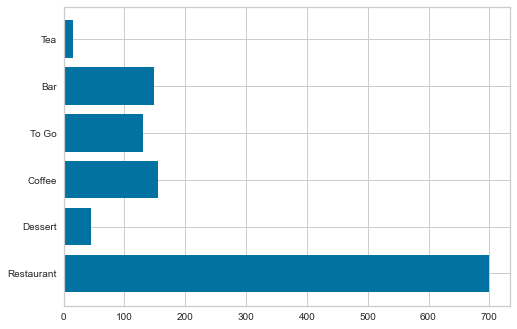

In [20]:
MTL_venues = {}
MTL_venues['Restaurant'] = montreal_neighborhood_venues[['Restaurant']].sum()[0]
MTL_venues['Dessert'] = montreal_neighborhood_venues[['Dessert']].sum()[0]
MTL_venues['Coffee'] = montreal_neighborhood_venues[['Coffee']].sum()[0]
MTL_venues['To Go'] = montreal_neighborhood_venues[['To Go']].sum()[0]
MTL_venues['Bar'] = montreal_neighborhood_venues[['Bar']].sum()[0]
MTL_venues['Tea'] = montreal_neighborhood_venues[['Tea']].sum()[0]

plt.barh([key for key in MTL_venues.keys()], MTL_venues.values())

# 4. Mapping the top 10 neighborhoods for each venue category

### Restaurants :

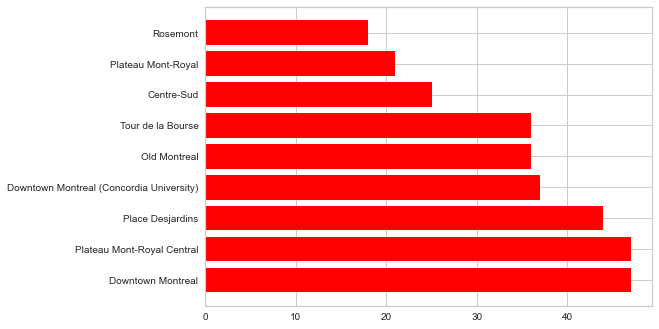

In [21]:
top_10_restaurants = montreal_neighborhood_venues.sort_values(by='Restaurant', ascending=False)[0:10].reset_index()
plt.barh(top_10_restaurants['Neighborhood'],top_10_restaurants['Restaurant'], color='red')

latitude, longitude = 45.508888, -73.561668

# create map using latitude and longitude values
map_montreal_restaurants = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, label, venues in zip(top_10_restaurants['Neighborhood Latitude'], top_10_restaurants['Neighborhood Longitude'], top_10_restaurants['Neighborhood'], top_10_restaurants['Restaurant']):
    if venues == 0:
        continue
    label = folium.Popup(label + ' ' + str(venues), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=venues/3,
        popup=label,
        color='red',
        fill=True,
        fill_opacity=0.5,
        parse_html=False).add_to(map_montreal_restaurants)  
    
map_montreal_restaurants

### Dessert Places :

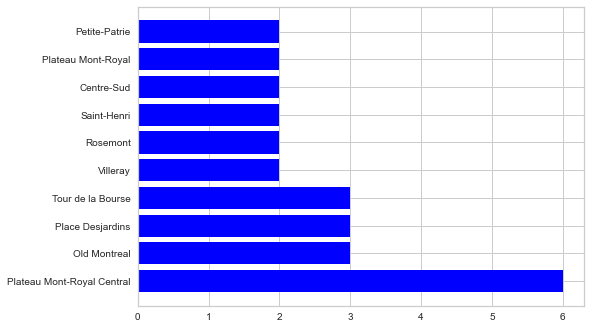

In [22]:
top_10_desserts = montreal_neighborhood_venues.sort_values(by='Dessert', ascending=False)[0:10].reset_index()
plt.barh(top_10_desserts['Neighborhood'],top_10_desserts['Dessert'], color='blue')

latitude, longitude = 45.508888, -73.561668

# create map using latitude and longitude values
map_montreal_dessert = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, label, venues in zip(top_10_restaurants['Neighborhood Latitude'], top_10_restaurants['Neighborhood Longitude'], top_10_restaurants['Neighborhood'], top_10_restaurants['Restaurant']):
    if venues == 0:
        continue
    label = folium.Popup(label + ' ' + str(venues), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=venues/3,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_montreal_dessert)  
    
map_montreal_dessert

### Coffee shops :

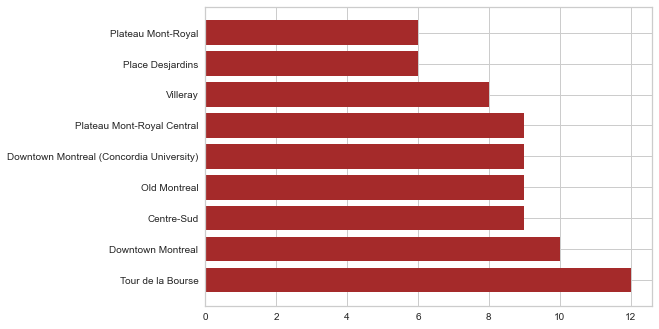

In [23]:
top_10_coffee = montreal_neighborhood_venues.sort_values(by='Coffee', ascending=False)[0:10].reset_index()
plt.barh(top_10_coffee['Neighborhood'],top_10_coffee['Coffee'], color='brown')

latitude, longitude = 45.508888, -73.561668

# create map using latitude and longitude values
map_montreal_coffee = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, label, venues in zip(top_10_restaurants['Neighborhood Latitude'], top_10_restaurants['Neighborhood Longitude'], top_10_restaurants['Neighborhood'], top_10_restaurants['Coffee']):
    if venues == 0:
        continue    
    label = folium.Popup(label + ' ' + str(venues), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=venues/3,
        popup=label,
        color='brown',
        fill=True,
        fill_opacity=0.5,
        parse_html=False).add_to(map_montreal_coffee)  
    
map_montreal_coffee

### To Go :

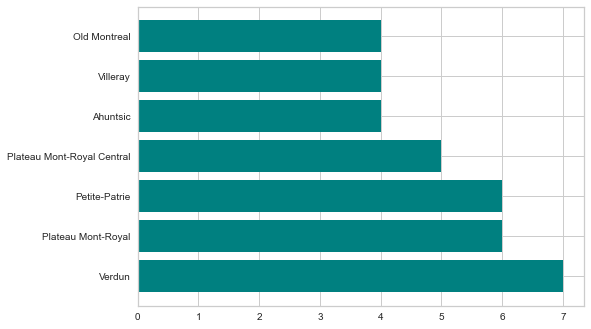

In [24]:
top_10_togo = montreal_neighborhood_venues.sort_values(by='To Go', ascending=False)[0:10].reset_index()
plt.barh(top_10_togo['Neighborhood'],top_10_togo['To Go'], color='teal')

latitude, longitude = 45.508888, -73.561668

# create map using latitude and longitude values
map_montreal_restaurants = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, label, venues in zip(top_10_restaurants['Neighborhood Latitude'], top_10_restaurants['Neighborhood Longitude'], top_10_restaurants['Neighborhood'], top_10_restaurants['Restaurant']):
    if venues == 0:
        continue    
    label = folium.Popup(label + ' ' + str(venues), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=venues/3,
        popup=label,
        color='teal',
        fill=True,
        fill_opacity=0.5,
        parse_html=False).add_to(map_montreal_restaurants)  
    
map_montreal_restaurants

### Bars :

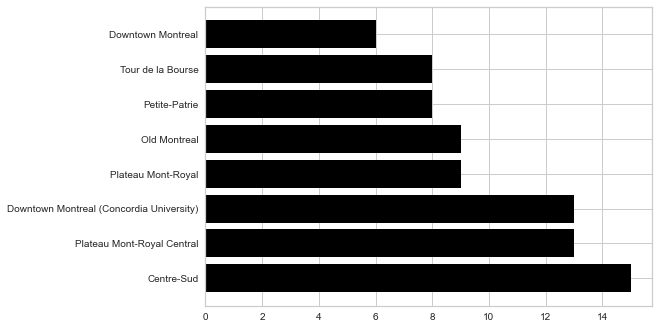

In [25]:
top_10_bar = montreal_neighborhood_venues.sort_values(by='Bar', ascending=False)[0:10].reset_index()
plt.barh(top_10_bar['Neighborhood'],top_10_bar['Bar'], color='black')

latitude, longitude = 45.508888, -73.561668

# create map using latitude and longitude values
map_montreal_restaurants = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, label, venues in zip(top_10_restaurants['Neighborhood Latitude'], top_10_restaurants['Neighborhood Longitude'], top_10_restaurants['Neighborhood'], top_10_restaurants['Restaurant']):
    if venues == 0:
        continue
    label = folium.Popup(label + ' ' + str(venues), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=venues/3,
        popup=label,
        color='black',
        fill=True,
        fill_opacity=0.5,
        parse_html=False).add_to(map_montreal_restaurants)  
    
map_montreal_restaurants

### Tea places :

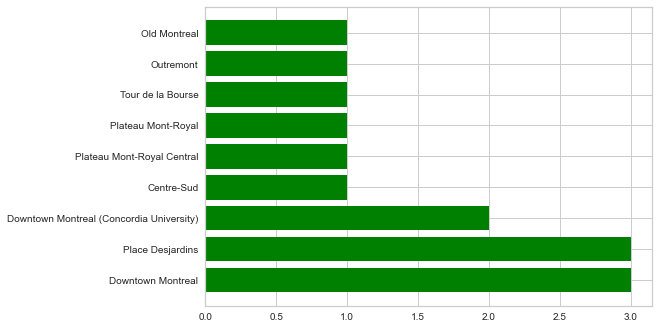

In [26]:
top_10_tea = montreal_neighborhood_venues.sort_values(by='Tea', ascending=False)[0:10].reset_index()
plt.barh(top_10_tea['Neighborhood'],top_10_tea['Tea'], color='green')

latitude, longitude = 45.508888, -73.561668

# create map using latitude and longitude values
map_montreal_restaurants = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, label, venues in zip(top_10_restaurants['Neighborhood Latitude'], top_10_restaurants['Neighborhood Longitude'], top_10_restaurants['Neighborhood'], top_10_restaurants['Restaurant']):
    if venues == 0:
        continue
    label = folium.Popup(label + ' ' + str(venues), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=venues/3,
        popup=label,
        color='green',
        fill=True,
        fill_opacity=0.5,
        parse_html=False).add_to(map_montreal_restaurants)  
    
map_montreal_restaurants

It seems like the top 10 neigborhoods for each venue type are always around the same area.

## Let's see which neighborhoods are the most often in the top 10 for every categories :

In [27]:
top_10_list = [top_10_restaurants, top_10_desserts, top_10_coffee, top_10_togo, top_10_bar, top_10_tea]
top_10_df = pd.DataFrame()

for df in top_10_list:
    top_10_df = top_10_df.append(df, ignore_index=True)

top_10_df['Neighborhood'].value_counts()

Plateau Mont-Royal                          10
Plateau Mont-Royal Central                   7
Downtown Montreal                            6
Old Montreal                                 6
Centre-Sud                                   5
Tour de la Bourse                            5
Place Desjardins                             4
Downtown Montreal (Concordia University)     4
Petite-Patrie                                4
Villeray                                     3
Rosemont                                     2
Saint-Henri                                  1
Outremont                                    1
Verdun                                       1
Ahuntsic                                     1
Name: Neighborhood, dtype: int64

It's fair to assume the Plateau Mont-Royal and Downtown Montreal are the places to go !

# 5. Training of the clustering algorithm

## Let's create a dataframe

The clusters will help us understand which neighborhoods are alike

In [28]:
montreal_neighborhood_venues_perc = pd.DataFrame()
montreal_neighborhood_venues_perc['Restaurant'] = montreal_neighborhood_venues['Restaurant'] / MTL_venues['Restaurant']
montreal_neighborhood_venues_perc['Dessert'] = montreal_neighborhood_venues['Dessert'] / MTL_venues['Dessert']
montreal_neighborhood_venues_perc['Coffee'] = montreal_neighborhood_venues['Coffee'] / MTL_venues['Coffee']
montreal_neighborhood_venues_perc['To Go'] = montreal_neighborhood_venues['To Go'] / MTL_venues['To Go']
montreal_neighborhood_venues_perc['Bar'] = montreal_neighborhood_venues['Bar'] / MTL_venues['Bar']
montreal_neighborhood_venues_perc['Tea'] = montreal_neighborhood_venues['Tea'] / MTL_venues['Tea']

In [29]:
montreal_neighborhood_venues_perc

Restaurant  \
Neighborhood      Neighborhood Latitude Neighborhood Longitude               
 Laval-sur-le-Lac 45.5526               -73.8507                  0.001431   
Ahuntsic          45.5394               -73.6513                  0.008584   
                  45.5467               -73.6718                  0.005722   
                  45.5528               -73.6411                  0.000000   
                  45.5741               -73.6507                  0.001431   
...                                                                    ...   
Villeray          45.5514               -73.6116                  0.002861   
Vimont            45.5984               -73.7159                  0.001431   
mount             45.4825               -73.5933                  0.002861   
                  45.4876               -73.6045                  0.000000   
Îles-Laval        45.5284               -73.8509                  0.000000   

                                                                Dessert  \
Neighborhood      Neighborhood Latitude Neighborhood Longitude            
 Laval-sur-le-Lac 45.5526               -73.8507                    0.0   
Ahuntsic          45.5394               -73.6513                    0.0   
                  45.5467               -73.6718                    0.0   
                  45.5528               -73.6411                    0.0   
                  45.5741               -73.6507                    0.0   
...                                                                 ...   
Villeray          45.5514               -73.6116                    0.0   
Vimont            45.5984               -73.7159                    0.0   
mount             45.4825               -73.5933                    0.0   
                  45.4876               -73.6045                    0.0   
Îles-Laval        45.5284               -73.8509                    0.0   

                                                                  Coffee  \
Neighborhood      Neighborhood Latitude Neighborhood Longitude             
 Laval-sur-le-Lac 45.5526               -73.8507                0.000000   
Ahuntsic          45.5394               -73.6513                0.006452   
                  45.5467               -73.6718                0.006452   
                  45.5528               -73.6411                0.000000   
                  45.5741               -73.6507                0.000000   
...                                                                  ...   
Villeray          45.5514               -73.6116                0.000000   
Vimont            45.5984               -73.7159                0.000000   
mount             45.4825               -73.5933                0.000000   
                  45.4876               -73.6045                0.000000   
Îles-Laval        45.5284               -73.8509                0.000000   

                                                                   To Go  \
Neighborhood      Neighborhood Latitude Neighborhood Longitude             
 Laval-sur-le-Lac 45.5526               -73.8507                0.000000   
Ahuntsic          45.5394               -73.6513                0.030769   
                  45.5467               -73.6718                0.015385   
                  45.5528               -73.6411                0.000000   
                  45.5741               -73.6507                0.007692   
...                                                                  ...   
Villeray          45.5514               -73.6116                0.030769   
Vimont            45.5984               -73.7159                0.000000   
mount             45.4825               -73.5933                0.000000   
                  45.4876               -73.6045                0.000000   
Îles-Laval        45.5284               -73.8509                0.000000   

                                                                     Bar  Tea  
Neighborhood   

In [30]:
X_train = montreal_neighborhood_venues[['Restaurant','Coffee','To Go','Bar']]
X_train

Restaurant  \
Neighborhood      Neighborhood Latitude Neighborhood Longitude               
 Laval-sur-le-Lac 45.5526               -73.8507                         1   
Ahuntsic          45.5394               -73.6513                         6   
                  45.5467               -73.6718                         4   
                  45.5528               -73.6411                         0   
                  45.5741               -73.6507                         1   
...                                                                    ...   
Villeray          45.5514               -73.6116                         2   
Vimont            45.5984               -73.7159                         1   
mount             45.4825               -73.5933                         2   
                  45.4876               -73.6045                         0   
Îles-Laval        45.5284               -73.8509                         0   

                                                                Coffee  To Go  \
Neighborhood      Neighborhood Latitude Neighborhood Longitude                  
 Laval-sur-le-Lac 45.5526               -73.8507                     0      0   
Ahuntsic          45.5394               -73.6513                     1      4   
                  45.5467               -73.6718                     1      2   
                  45.5528               -73.6411                     0      0   
                  45.5741               -73.6507                     0      1   
...                                                                ...    ...   
Villeray          45.5514               -73.6116                     0      4   
Vimont            45.5984               -73.7159                     0      0   
mount             45.4825               -73.5933                     0      0   
                  45.4876               -73.6045                     0      0   
Îles-Laval        45.5284               -73.8509                     0      0   

                                                                Bar  
Neighborhood      Neighborhood Latitude Neighborhood Longitude       
 Laval-sur-le-Lac 45.5526               -73.8507                  0  
Ahuntsic          45.5394               -73.6513                  0  
                  45.5467               -73.6718                  2  
                  45.5528               -73.6411                  0  
                  45.5741               -73.6507                  0  
...                                                             ...  
Villeray          45.5514               -73.6116                  0  
Vimont            45.5984               -73.7159                  0  
mount             45.4825               -73.5933                  0  
                  45.4876               -73.6045                  0  
Îles-Laval        45.5284               -73.8509                  0  

[117 rows x 4 columns]

## Training of the model

In [31]:
model = KMeans(3, random_state=0)
model.fit(X_train)
labels = model.labels_

In [32]:
clustered_df = X_train.copy()
clustered_df['Labels'] = labels
clustered_df.reset_index(inplace=True)
clustered_df['Neighborhood'] = montreal_neighborhood_venues_perc.reset_index()[['Neighborhood']]

For n cluster = 2 silhouette score is 0.8081782353703728
For n cluster = 3 silhouette score is 0.701607760167006
For n cluster = 4 silhouette score is 0.6108623032560407
For n cluster = 5 silhouette score is 0.5988398544679313
For n cluster = 6 silhouette score is 0.6106251465121602
For n cluster = 7 silhouette score is 0.4720188183431039
For n cluster = 8 silhouette score is 0.49811583507159957
For n cluster = 9 silhouette score is 0.4612820164662196
For n cluster = 10 silhouette score is 0.4668577335688391


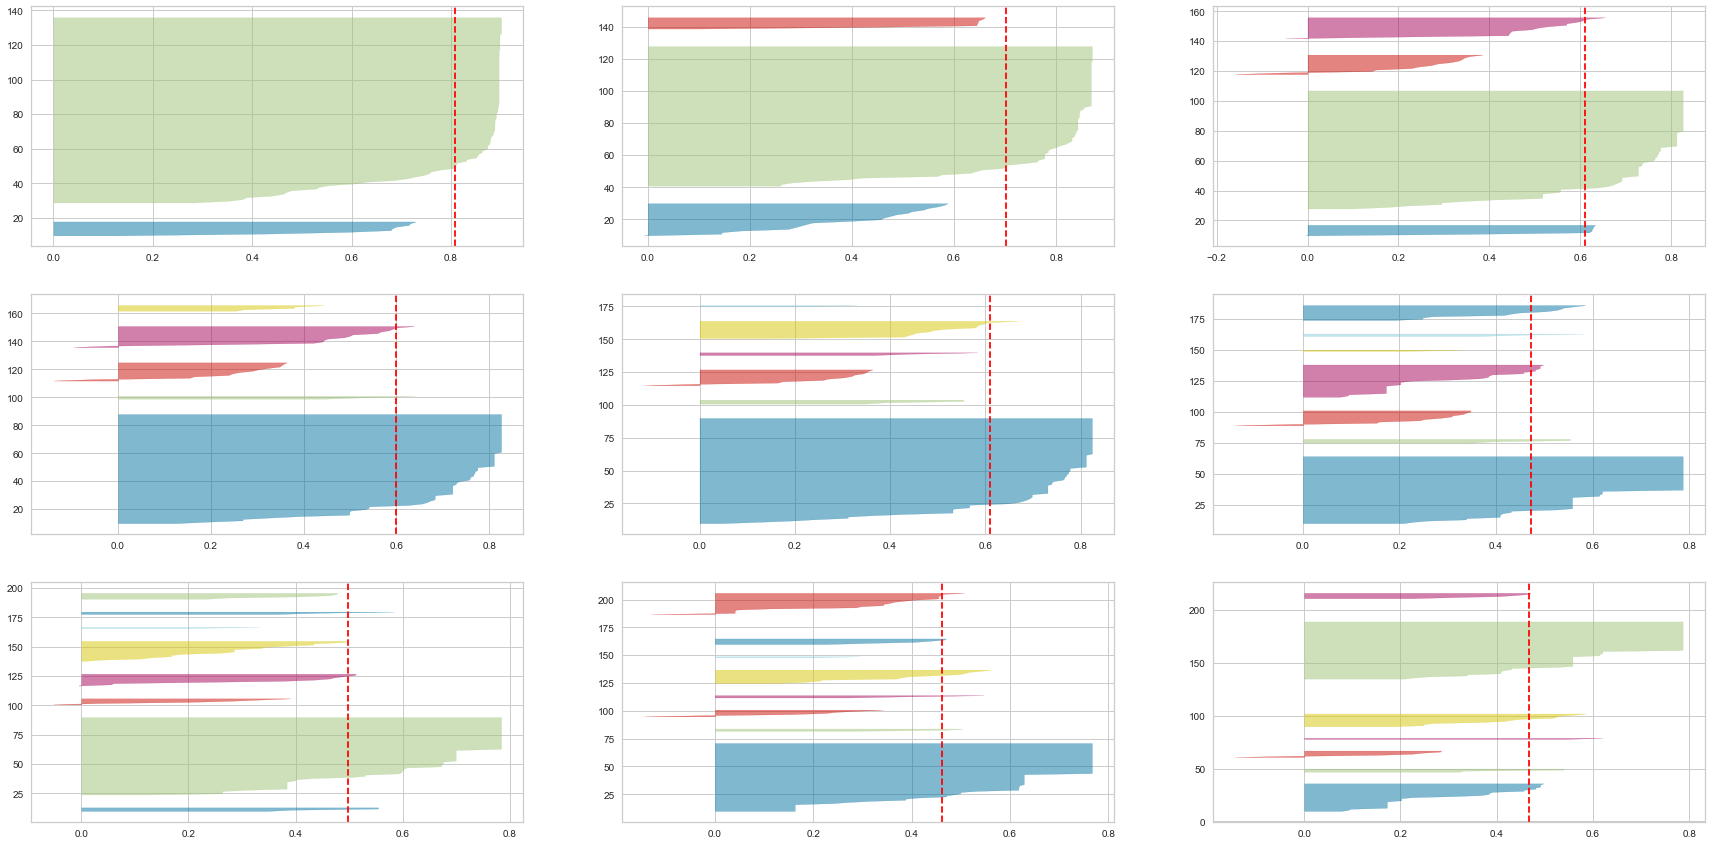

In [33]:
fig, ax = plt.subplots(3, 3, figsize=(30,15))

sil_dict = {}

for i, k in enumerate([2, 3, 4, 5, 6, 7, 8, 9, 10]):
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=k, init='k-means++', random_state=0)
    q, mod = divmod(i, 3)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q][mod])
    visualizer.fit(X_train)
    
    print('For n cluster =', k,'silhouette score is', silhouette_score(X_train, km.labels_))
    
    sil_dict[k] = silhouette_score(X_train, km.labels_)

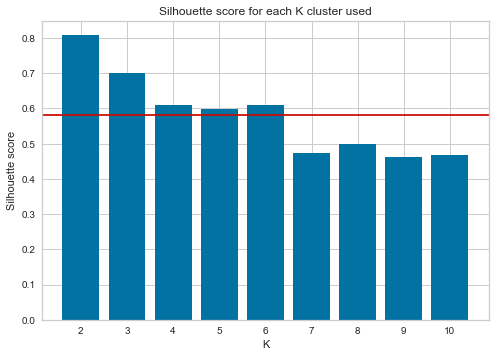

In [34]:
plt.bar(sil_dict.keys(), sil_dict.values())
plt.title('Silhouette score for each K cluster used')
plt.xlabel('K')
plt.ylabel('Silhouette score')
plt.xticks(np.arange(2, 11, 1))
plt.axhline(y = np.mean(list(sil_dict.values())), color = 'r', linestyle = '-')

In [35]:
clustered_df

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Restaurant,Coffee,To Go,Bar,Labels
0,Laval-sur-le-Lac,45.5526,-73.8507,1,0,0,0,1
1,Ahuntsic,45.5394,-73.6513,6,1,4,0,1
2,Ahuntsic,45.5467,-73.6718,4,1,2,2,1
3,Ahuntsic,45.5528,-73.6411,0,0,0,0,1
4,Ahuntsic,45.5741,-73.6507,1,0,1,0,1
...,...,...,...,...,...,...,...,...
112,Villeray,45.5514,-73.6116,2,0,4,0,1
113,Vimont,45.5984,-73.7159,1,0,0,0,1
114,mount,45.4825,-73.5933,2,0,0,0,1
115,mount,45.4876,-73.6045,0,0,0,0,1


# 6. Analysis of the clusters

In [36]:
latitude, longitude = 45.508888, -73.561668
colors = ['blue','red','teal','purple','black','green', 'yellow']

# create map of Manhattan using latitude and longitude values
map_montreal_labels = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label, cluster in zip(clustered_df['Neighborhood Latitude'], clustered_df['Neighborhood Longitude'], clustered_df['Neighborhood'], clustered_df['Labels']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=colors[cluster],
        fill=True,
        fill_opacity=0.5,
        parse_html=False).add_to(map_montreal_labels)  
    
map_montreal_labels

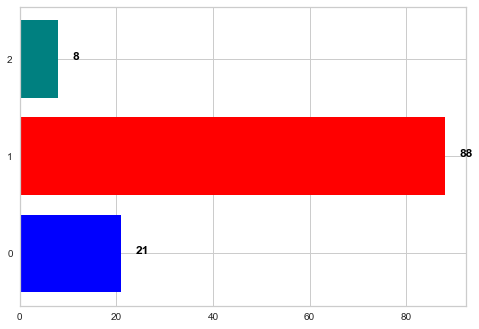

In [37]:
barh_w = clustered_df['Labels'].value_counts().sort_index()
barh_y = clustered_df['Labels'].value_counts().sort_index().index

plt.barh(barh_y ,barh_w , color=colors)
plt.yticks([0,1,2])

for i, v in enumerate(barh_w):
    plt.text(v + 3, i, str(v), color='black', fontweight='bold')

## Let's plot the percentage of each venue category contained in each cluster

Cluster label : 0
21 neighborhoods in the cluster


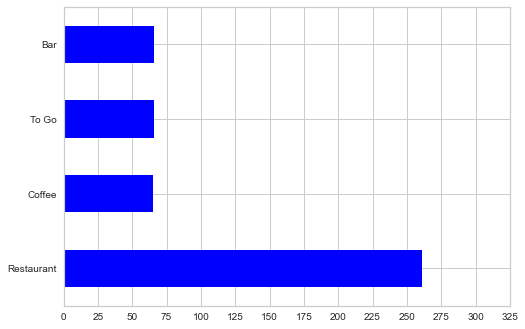

Cluster label : 1
88 neighborhoods in the cluster


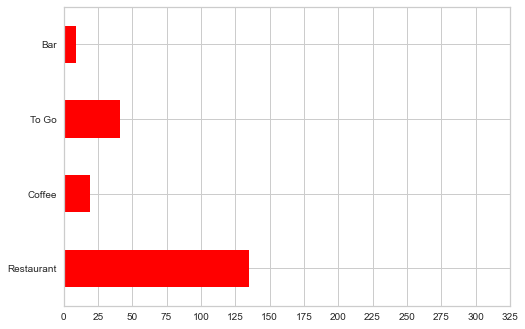

Cluster label : 2
8 neighborhoods in the cluster


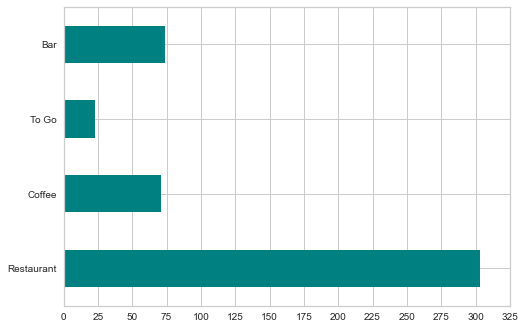

In [38]:
xtick = np.arange(0, 0.5, step=0.05)


for cluster in range(len(clustered_df['Labels'].unique())):
    
    print('Cluster label :', cluster)
    print(clustered_df['Labels'].value_counts(sort=False)[cluster], 'neighborhoods in the cluster')
    clustered_df[clustered_df['Labels'] == cluster][['Restaurant','Coffee','To Go','Bar']].sum().plot(kind='barh', color=colors[cluster])
    plt.xticks(np.arange(0, 350, step=25))
    plt.show()
    

## So, where to go to find a restaurant ?

In [39]:
clustered_df[clustered_df['Labels'] == 2]

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Restaurant,Coffee,To Go,Bar,Labels
15,Centre-Sud,45.5186,-73.5545,25,9,3,15,2
31,Downtown Montreal,45.5005,-73.5684,31,10,1,5,2
33,Downtown Montreal,45.5052,-73.5622,47,7,2,6,2
34,Downtown Montreal (Concordia University),45.4987,-73.5793,37,9,3,13,2
64,Old Montreal,45.5057,-73.5550,36,9,4,9,2
73,Place Desjardins,45.5066,-73.5623,44,6,3,5,2
77,Plateau Mont-Royal Central,45.5176,-73.5804,47,9,4,13,2
106,Tour de la Bourse,45.5061,-73.5573,36,12,3,8,2


# 7. Conclusion

Out of 117 neighborhoods, the 8 that are in the last cluster have nearly half of the restaurants of Montréal. This cluster have the most restaurants, bars and coffee shop of the three ! The map also shows all the neighborhoods of the cluster are very close to one another. If you are looking for a restaurant in Montréal, the list below should guide you very well !

In [40]:
clustered_df[clustered_df['Labels'] == 2][['Neighborhood', 'Restaurant','Coffee','To Go','Bar']].set_index('Neighborhood')

,Restaurant,Coffee,To Go,Bar
Neighborhood,,,,
Centre-Sud,25,9,3,15
Downtown Montreal,31,10,1,5
Downtown Montreal,47,7,2,6
Downtown Montreal (Concordia University),37,9,3,13
Old Montreal,36,9,4,9
Place Desjardins,44,6,3,5
Plateau Mont-Royal Central,47,9,4,13
Tour de la Bourse,36,12,3,8
